In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Set the desired folder path inside your Google Drive
folder_path = '/content/drive/MyDrive/Image_denoising'

# Change the working directory to the desired folder
os.chdir(folder_path)

In [ ]:
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Image_denoising


In [ ]:
import numpy as np
import cv2

# Path to the folder containing the images
import os
import cv2
import numpy as np

folder_path = '/content/drive/MyDrive/Image_denoising/Train/high'

# List to store the image arrays
image_arrays = []

# Get a sorted list of all image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Loop through the sorted list of image files
for filename in image_files:
    # Read the image using OpenCV
    image = cv2.imread(os.path.join(folder_path, filename))
    # Convert the image to grayscale (optional, if needed)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Append the image array to the list
    image_arrays.append(image)

# Convert the list of arrays to a single numpy array
image_arrays_np = np.array(image_arrays)

# Check the shape of the numpy array
print(image_arrays_np.shape)



(485, 400, 600, 3)


In [ ]:
folder_path_2 = '/content/drive/MyDrive/Image_denoising/Train/low'

# List to store the image arrays
noised_image = []
image_files_2 = sorted([f for f in os.listdir(folder_path_2) if f.endswith('.jpg') or f.endswith('.png')])
# Loop through all the image files in the folder
for filename in image_files_2:
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add more extensions if needed
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(folder_path_2, filename))
        # Convert the image to grayscale (optional, if needed)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Append the image array to the list
        noised_image.append(image)

# Convert the list of arrays to a single numpy array
noised_arrays_np = np.array(noised_image)

# Check the shape of the numpy array
print("Shape of the array:", noised_arrays_np.shape)

Shape of the array: (485, 400, 600, 3)


In [ ]:

# Function to resize a single image
def resize_image(image, target_size=(240,160)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

# Example with a batch of images
def resize_images(images, target_size=(240,160)):
    return np.array([resize_image(image, target_size) for image in images])

# Resize the image arrays
resized_image_arrays_np = resize_images(image_arrays_np)
resized_noised_arrays_np = resize_images(noised_arrays_np)

In [ ]:
import matplotlib.pyplot as plt


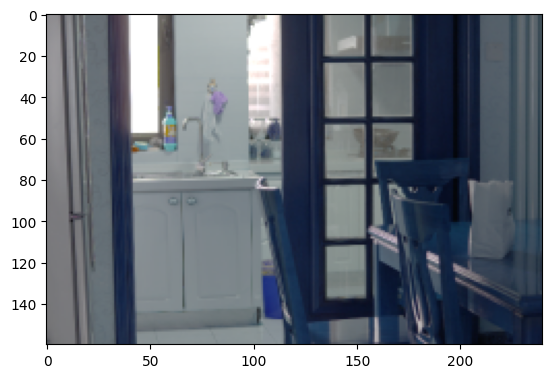

In [ ]:
plt.imshow(resized_image_arrays_np[5])

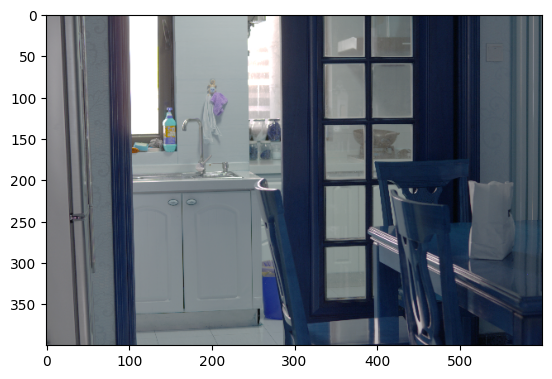

In [ ]:
plt.imshow(image_arrays_np[5])

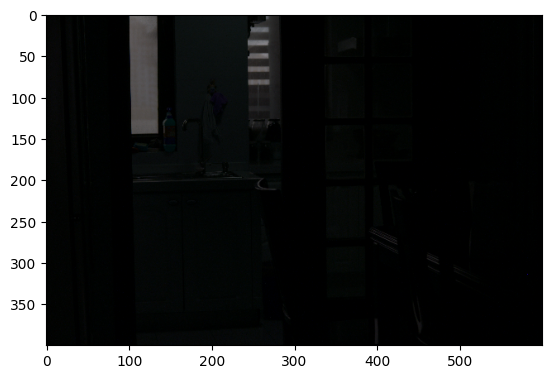

In [ ]:
plt.imshow(noised_arrays_np[5])

In [ ]:
noisy_images = resized_noised_arrays_np.astype('float32') / 255.0
clean_images = resized_image_arrays_np.astype('float32') / 255.0

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add

def build_dncnn_model(input_shape):
    input_img = Input(shape=input_shape)

    # First Conv layer
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)

    # Intermediate Conv layers with batch normalization
    for _ in range(15):
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Last Conv layer
    x = Conv2D(3, (3, 3), padding='same')(x)

    # Residual learning
    output_img = Add()([input_img, x])

    # Build and compile the model
    dncnn = Model(input_img, output_img)
    dncnn.compile(optimizer='adam', loss='mean_squared_error')

    return dncnn

# Define the input shape based on your images
input_shape = (160, 240, 3)
dncnn = build_dncnn_model(input_shape)

# Display the model architecture
dncnn.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 240, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 160, 240, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 160, 240, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 160, 240, 64)         36928     ['activation[0][0]']          
                                                                                              

In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * noisy_images.shape[0])

train_noisy, test_noisy = noisy_images[:train_size], noisy_images[train_size:]
train_clean, test_clean = clean_images[:train_size], clean_images[train_size:]

In [ ]:
train_noisy.shape

(388, 160, 240, 3)

In [ ]:
train_clean.shape

(388, 160, 240, 3)

In [ ]:
dncnn.fit(train_noisy, train_clean, epochs=10, batch_size=32)

Epoch 1/10
13/13 [==============================] - 34s 1s/step - loss: 0.2633
Epoch 2/10
13/13 [==============================] - 15s 1s/step - loss: 0.0403
Epoch 3/10
13/13 [==============================] - 16s 1s/step - loss: 0.0333
Epoch 4/10
13/13 [==============================] - 16s 1s/step - loss: 0.0309
Epoch 5/10
13/13 [==============================] - 16s 1s/step - loss: 0.0314
Epoch 6/10
13/13 [==============================] - 16s 1s/step - loss: 0.0325
Epoch 7/10
13/13 [==============================] - 17s 1s/step - loss: 0.0320
Epoch 8/10
13/13 [==============================] - 17s 1s/step - loss: 0.0300
Epoch 9/10
13/13 [==============================] - 17s 1s/step - loss: 0.0307
Epoch 10/10
13/13 [==============================] - 17s 1s/step - loss: 0.0325


In [ ]:
denoised_image=dncnn.predict(test_noisy)

4/4 [==============================] - 2s 459ms/step


In [ ]:
denoised_image.shape

(97, 160, 240, 3)

In [ ]:
test_clean.shape

(97, 160, 240, 3)

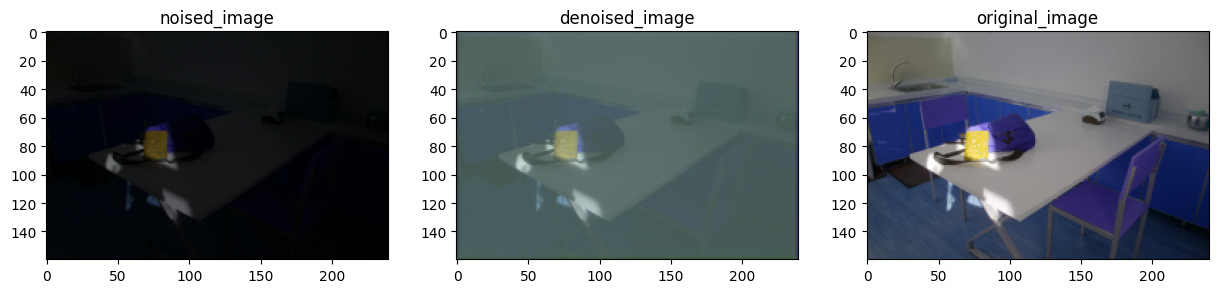

In [ ]:
fig , axe= plt.subplots(1,3,figsize=(15,5))
i=1
axe[0].imshow(test_noisy[i])
axe[0].set_title('noised_image')
axe[1].imshow(denoised_image[i])
axe[1].set_title('denoised_image')
axe[2].imshow(test_clean[i])
axe[2].set_title('original_image')
plt.show()

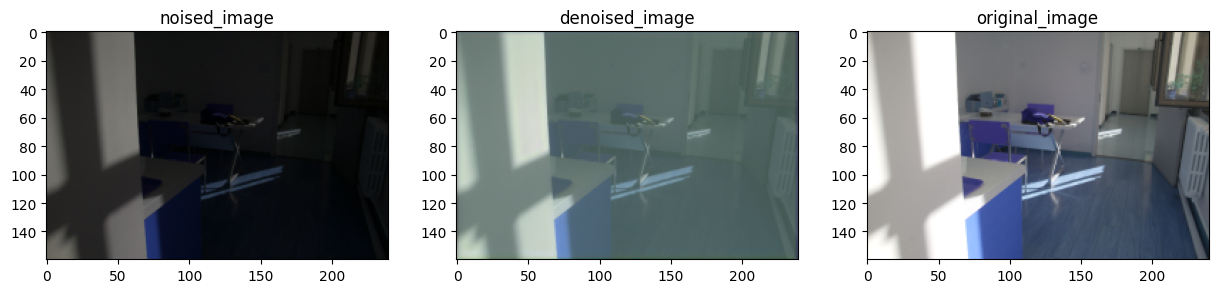

In [ ]:
fig , axe= plt.subplots(1,3,figsize=(15,5))
i=4
axe[0].imshow(test_noisy[i])
axe[0].set_title('noised_image')
axe[1].imshow(denoised_image[i])
axe[1].set_title('denoised_image')
axe[2].imshow(test_clean[i])
axe[2].set_title('original_image')
plt.show()

In [ ]:


def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0  # Since the images are normalized
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr


In [ ]:
psnr_values = [calculate_psnr(test_clean[i], denoised_image[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f"Average PSNR value is: {average_psnr} dB")


Average PSNR value is: 17.018815721332423 dB


In [ ]:
dncnn.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
